# INST728E - Module 5. Temporal Analysis

In this section, we will cover a few simple analysis techniques to garner some small insights rapidly.

- Time parsing
- Frequency Graph
- Keyword Frequency

### Zooming in on an event

Then we'll look at relevant tweets and answer some questions:

- Top users
- Top hash tags
- Top URLs
- Top images
- Most retweeted tweet

In [1]:
%matplotlib inline

import datetime
import json
import gzip
import glob
import os
import string

import numpy as np

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

## Defining An Event

The following notebook walks us through a number of capabilities or common pieces of functionality one may want when analyzing Twitter following a crisis.
We will start by defining information for an event for which we have data.

You can replace this dictionary or add to it with an event of your own! In fact, you'll need to do so for this module's homework.

In [67]:
crisisInfo = {
    "Women's March": {
        "name": "Women's March 2017",
        "time": 1484992800, # 21 January 2017, 6:58 UTC to 08:11 UTC
        "directory": "womensmarch",    # Where do we find the relevant files
        "keywords": [    # How can we describe this event?
            "women's march","resist", "notmypresident","inauguration","women's right","human right","planned parenthood"
        ],
        "box": {    # Where did this event occur?
            "lowerLeftLon": 2.54563,
            "lowerLeftLat": 49.496899,
            "upperRightLon": 6.40791,
            "upperRightLat": 51.5050810,
        }
    },
}

<hr>

## Reading Tweets

The first thing we do is read in tweets from a directory of compressed files. Our collection of compressed tweets is in the 00_data directory, so we'll use pattern matching (called "globbing") to find all the tweet files in the given directory.

Then, for each file, we'll open it, read each line (which is a tweet in JSON form), and build an object out of it. As part of this process, we will extract each tweet's post time and create a map from minute timestamps to the tweets posted during that minute.

In [3]:
selectedCrisis = "Women's March"

# Determine host-specific location of data
tweetDirectory = crisisInfo[selectedCrisis]["directory"]
tweetGlobPath = os.path.sep + os.path.join("Users", "yutingliao", "Desktop", "INST728 E",
                             "Dataset_women'smarch",tweetDirectory,"part-00*.gz")

print ("Reading files from:", tweetGlobPath)

# Dictionary for mapping dates to data
frequencyMap = {}

# Twitter's time format, for parsing the created_at date
timeFormat = "%a %b %d %H:%M:%S +0000 %Y"

for tweetFilePath in glob.glob(tweetGlobPath):
    print ("Reading File:", tweetFilePath)

    for line in gzip.open(tweetFilePath, 'rb'):

        # Convert from bytes to UTF8 string
        decoded_line = line.decode("utf8")
        
        # Try to read tweet JSON into object
        tweetObj = None
        try:
            tweetObj = json.loads(decoded_line)
        except json.JSONDecodeError as jde:
            print("JSON Decode Error:", decoded_line)
            continue

        # Deleted status messages and protected status must be skipped
        if ( "delete" in tweetObj.keys() or "status_withheld" in tweetObj.keys() ):
            continue

        # Try to extract the time of the tweet
        try:
            currentTime = datetime.datetime.strptime(tweetObj['created_at'], timeFormat)
        except:
            print("Error parsing time on line:", decoded_line)
            raise

        # Flatten this tweet's time
        currentTime = currentTime.replace(second=0)

        # If our frequency map already has this time, use it, otherwise add
        extended_list = frequencyMap.get(currentTime, [])
        extended_list.append(tweetObj)
        frequencyMap[currentTime] = extended_list

Reading files from: /Users/yutingliao/Desktop/INST728 E/Dataset_women'smarch/womensmarch/part-00*.gz
Reading File: /Users/yutingliao/Desktop/INST728 E/Dataset_women'smarch/womensmarch/part-00000.gz
Reading File: /Users/yutingliao/Desktop/INST728 E/Dataset_women'smarch/womensmarch/part-00001.gz
Reading File: /Users/yutingliao/Desktop/INST728 E/Dataset_women'smarch/womensmarch/part-00002.gz
Reading File: /Users/yutingliao/Desktop/INST728 E/Dataset_women'smarch/womensmarch/part-00003.gz
Reading File: /Users/yutingliao/Desktop/INST728 E/Dataset_women'smarch/womensmarch/part-00004.gz
JSON Decode Error: Connection established.

Reading File: /Users/yutingliao/Desktop/INST728 E/Dataset_women'smarch/womensmarch/part-00005.gz
Reading File: /Users/yutingliao/Desktop/INST728 E/Dataset_women'smarch/womensmarch/part-00006.gz
Reading File: /Users/yutingliao/Desktop/INST728 E/Dataset_women'smarch/womensmarch/part-00007.gz
Reading File: /Users/yutingliao/Desktop/INST728 E/Dataset_women'smarch/womensma

Reading File: /Users/yutingliao/Desktop/INST728 E/Dataset_women'smarch/womensmarch/part-00082.gz
Reading File: /Users/yutingliao/Desktop/INST728 E/Dataset_women'smarch/womensmarch/part-00083.gz
Reading File: /Users/yutingliao/Desktop/INST728 E/Dataset_women'smarch/womensmarch/part-00084.gz
Reading File: /Users/yutingliao/Desktop/INST728 E/Dataset_women'smarch/womensmarch/part-00085.gz
Reading File: /Users/yutingliao/Desktop/INST728 E/Dataset_women'smarch/womensmarch/part-00086.gz
Reading File: /Users/yutingliao/Desktop/INST728 E/Dataset_women'smarch/womensmarch/part-00087.gz
Reading File: /Users/yutingliao/Desktop/INST728 E/Dataset_women'smarch/womensmarch/part-00088.gz
Reading File: /Users/yutingliao/Desktop/INST728 E/Dataset_women'smarch/womensmarch/part-00089.gz
Reading File: /Users/yutingliao/Desktop/INST728 E/Dataset_women'smarch/womensmarch/part-00090.gz
Reading File: /Users/yutingliao/Desktop/INST728 E/Dataset_women'smarch/womensmarch/part-00091.gz
Reading File: /Users/yutinglia

Reading File: /Users/yutingliao/Desktop/INST728 E/Dataset_women'smarch/womensmarch/part-00166.gz
Reading File: /Users/yutingliao/Desktop/INST728 E/Dataset_women'smarch/womensmarch/part-00167.gz


In [49]:
# Fill in any gaps
times = sorted(frequencyMap.keys())
firstTime = times[0]
lastTime = times[-1]
thisTime = firstTime

# We want to look at per-minute data, so we fill in any missing minutes
timeIntervalStep = datetime.timedelta(0, 60)    # Time step in seconds
while ( thisTime <= lastTime ):

    frequencyMap[thisTime] = frequencyMap.get(thisTime, [])
        
    thisTime = thisTime + timeIntervalStep

# Count the number of minutes
print ("Start Time:", firstTime)
print ("Stop Time:", lastTime)
print ("Processed Times:", len(frequencyMap))
    
# Count all the tweets per minute
print ("Processed Tweet Count:", np.sum([len(x) for x in frequencyMap.values()]))

Start Time: 2017-01-17 23:59:00
Stop Time: 2017-01-24 23:59:00
Processed Times: 10081
Processed Tweet Count: 2550293


### Twitter Timeline 

To build a timeline of Twitter usage, we can simply plot the number of tweets posted per minute.

Event Time: 2017-01-21 10:00:00
Time Frame: 2017-01-17 23:59:00 2017-01-24 23:59:00


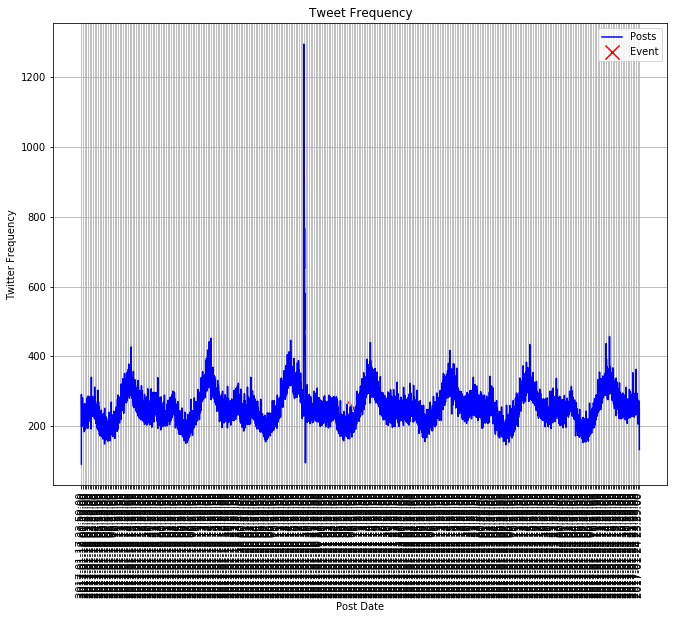

In [68]:
# Get data about our crisis
selectedCrisis = "Women's March"

crisisMoment = crisisInfo[selectedCrisis]["time"] # When did it occur by epoch time
crisisTime = datetime.datetime.utcfromtimestamp(crisisMoment) # Convert to datetime
crisisTime = crisisTime.replace(second=0) # Flatten to a specific minute

# Print converted time
print ("Event Time:", crisisTime)

# Create a new figure in which to plot minute-by-minute tweet count
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)

plt.title("Tweet Frequency")

# Sort the times into an array for future use
sortedTimes = sorted(frequencyMap.keys())

# What time span do these tweets cover?
print ("Time Frame:", sortedTimes[0], sortedTimes[-1])

# Get a count of tweets per minute
postFreqList = [len(frequencyMap[x]) for x in sortedTimes]

# We'll have ticks every few minutes (more clutters the graph)
smallerXTicks = range(0, len(sortedTimes), 30)
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

# Plot the post frequency
ax.plot(range(len(frequencyMap)), postFreqList, color="blue", label="Posts")

# Get the index for when our crisis occurred
crisisXCoord = sortedTimes.index(crisisTime)
ax.scatter([crisisXCoord], [np.mean(postFreqList)], c="r", marker="x", s=200, label="Event")

ax.grid(b=True, which=u'major')
ax.legend()

ax.set_xlabel("Post Date")
ax.set_ylabel("Twitter Frequency")

plt.show()

## Zooming in on an Event


Let's zoom in on who was tweeting about this event as well and what they are saying:

- Top users
- Top hash tags
- Top URLs
- Most retweeted tweet

For each question, let's look between generally popular and relevant tweets. "Relevance" comes in several forms though: temporal (posted around the same time), textual (mentions the event), social (mentions someone who experienced the event), or spatial (happened in/mentions the same place).

We'll first look at tweets that happened right after the event.

In [54]:
# List of relevant tweet times
after_event_times = []

relevant_time_span = 60 # Let's look at the first few minutes after the event

current_time_span = 0
for current_time in sortedTimes:
    if ( current_time >= crisisTime ):
        after_event_times.append(current_time)
        current_time_span += 1
        
    if ( current_time_span > relevant_time_span ):
        break

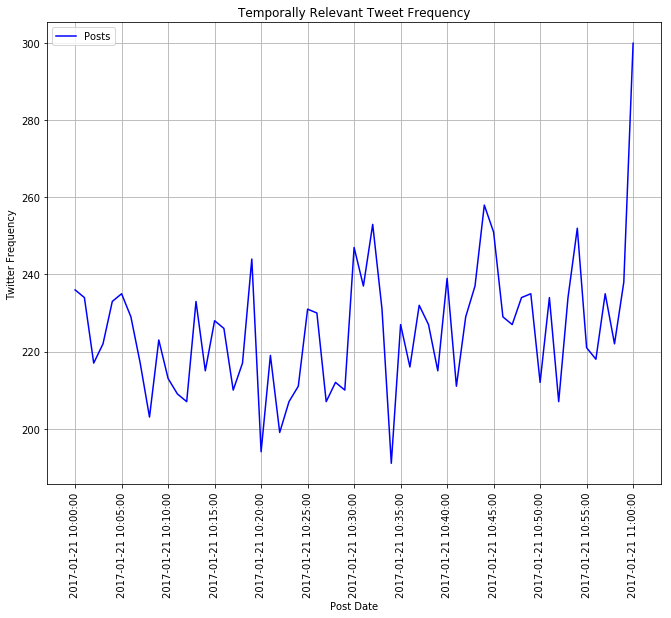

In [55]:
# Create a new figure in which to plot minute-by-minute tweet count
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)

plt.title("Temporally Relevant Tweet Frequency")

# Get a count of tweets per minute
postFreqList = [len(frequencyMap[x]) for x in after_event_times]

# We'll have ticks every few minutes (more clutters the graph)
smallerXTicks = range(0, len(after_event_times), 5)
plt.xticks(smallerXTicks, [after_event_times[x] for x in smallerXTicks], rotation=90)

# Plot the post frequency
ax.plot(range(len(after_event_times)), postFreqList, color="blue", label="Posts")

ax.grid(b=True, which=u'major')
ax.legend()

ax.set_xlabel("Post Date")
ax.set_ylabel("Twitter Frequency")

plt.show()

### What were people saying during this time?

In [56]:
temporally_relevant_tweets = [tweet 
                              for rel_time in after_event_times 
                              for tweet in frequencyMap[rel_time]]

print("Tweet Count:", len(temporally_relevant_tweets))

Tweet Count: 13770


In [57]:
tokenizer = TweetTokenizer()
stops = stopwords.words("english")

# This list comprehension iterates through the tweet_list list, and for each
#  tweet, it tokenizes the tweet text
tokens = [
        token.lower() 
         for tweet in temporally_relevant_tweets 
             for token in tokenizer.tokenize(tweet["text"])
        ]
tokens = list(filter(lambda x: x not in stops and len(x) > 3, tokens))

print("Total Token Count:", len(tokens))
print("Unique Token Count:", len(set(tokens)))

tokens_freq = nltk.FreqDist(tokens)

print("\nFrequent Tokens:")
for token, count in tokens_freq.most_common(50):
    print(token, count)

Total Token Count: 83627
Unique Token Count: 56953

Frequent Tokens:
الله 278
اللهم 257
170121 143
trump 129
love 125
like 116
5555555555 113
#iheartawards 111
#bestfanarmy 87
يارب 79
2017 79
today 79
https 76
time 75
people 72
para 72
good 71
video 67
@youtube 59
سبحان 57
life 57
want 55
know 52
world 51
mais 49
free 49
أعوذ 49
girl 48
قلبي 46
العظيم 46
need 45
think 45
never 44
first 44
بعدد 43
back 42
look 42
right 41
thanks 41
live 41
come 41
pour 41
follow 41
الدنيا 40
best 40
عذاب 39
obama 39
#now2016 39
como 39
happy 38


In [58]:
# This list comprehension iterates through the tweet_list list, and for each
#  tweet, it iterates through the hashtags list
htags = [
        hashtag["text"].lower() 
         for tweet in temporally_relevant_tweets 
             for hashtag in tweet["entities"]["hashtags"]
        ]

print("Total Hashtag Count:", len(htags))
print("Unique Hashtag Count:", len(set(htags)))

htags_freq = nltk.FreqDist(htags)

print("\nFrequent Hashtags:")
for tag, count in htags_freq.most_common(20):
    print(tag, count)

Total Hashtag Count: 5617
Unique Hashtag Count: 3768

Frequent Hashtags:
iheartawards 111
bestfanarmy 87
now2016 39
세븐틴 36
aldubourhappiness 35
littlemonsters 34
bestmusicvideo 27
inauguration 20
محاصره_ارهابيين_بجده 18
lovatics 17
nowladygaga 16
superbabysjourney 15
harmonizers 15
seventeen 15
nowplaying 14
아이오아이 14
bts 13
bigolive 13
사설토토추천사이트 13
rtした人全員フォローする 12


In [59]:
# This list comprehension iterates through the tweet_list list, and for each
#  tweet, it iterates through the author list
authors = [tweet["user"]["screen_name"].lower() for tweet in temporally_relevant_tweets]

print("Total Author Count:", len(authors))
print("Unique Author Count:", len(set(authors)))

author_freq = nltk.FreqDist(authors)

print("\nActive Users:")
for author, count in author_freq.most_common(20):
    print(author, count)

Total Author Count: 13770
Unique Author Count: 13649

Active Users:
mzawan1 3
marichubatang1 3
jmohadreda 3
destiny041772 3
lotekzttus86jd1 3
rhiymez 3
ringknightsaki 2
ilymycal 2
paoloigna1 2
shnwnnnnhh 2
helloqtie 2
mwki0wcyj8zhlzp 2
satiys18 2
ccsworld21a 2
dolove_thdus 2
roslynksh 2
sarahwright323 2
aciream23 2
cgalgale 2
gaelcancelxx 2


In [60]:
# This list comprehension iterates through the tweet_list list, and for each
#  tweet, it iterates through the URL list
urls = [
        url["expanded_url"]
         for tweet in temporally_relevant_tweets 
             for url in tweet["entities"]["urls"]
        ]

print("Total URL Count:", len(urls))
print("Unique URL Count:", len(set(urls)))

urls_freq = nltk.FreqDist(urls)

print("\nCommon URLs:")
for url, count in urls_freq.most_common(20):
    print(url, count)

Total URL Count: 4219
Unique URL Count: 2807

Common URLs:
None 753
http://du3a.org 244
http://d3waapp.org/ 91
http://ghared.com 61
http://7asnat.com/ 41
http://zad-muslim.com 27
http://bit.ly/2jJtpA6 25
http://fllwrs.com 20
http://bit.ly/2kbAYfQ 16
http://www.totobet1.com 14
http://bit.ly/2iWguH3 10
http://nico.ms/sm30474818 7
http://bnent.jp/optw/ 7
http://nico.ms/sm30475339 6
http://bnent.jp/optc-den2e/ 5
https://www.instagram.com/p/BPhdztbjHil/ 5
http://bnent.jp/optc-kr/ 4
https://twitter.com/5SOS/status/753850038707589120 4
https://twitter.com/5HVotingStats/status/816637289761796096 3
http://gharred.net/GharredChannels.aspx 3


### Most retweeted tweet AFTER event

In [61]:
# Find retweets
retweets = list(filter(lambda x: "retweeted_status" in x, temporally_relevant_tweets))
print("Retweet Count:", len(retweets))

# But we also want to filter out retweets whose original tweet
#  was posted BEFORE our event
retweets = list(filter(
    lambda tweet: crisisTime <= datetime.datetime.strptime(tweet["retweeted_status"]["created_at"], timeFormat),
    retweets
))
print("Recent Retweet Count:", len(retweets))

# For each retweet, get its pair
rt_pairs = [(tweet["retweeted_status"]["id"], tweet["retweeted_status"]["retweet_count"]) 
          for tweet in retweets]

# Get the unique tweet IDs
uniq_ids = set([x[0] for x in rt_pairs])

# Map retweet IDs to their counts
rt_map = {}
for local_id in uniq_ids:
    max_rt_count = max([x[1] for x in filter(lambda x: x[0] == local_id, rt_pairs)])
    rt_map[local_id] = max_rt_count
    
# Sort the retweets by count
top_5_rts = sorted(rt_map, key=rt_map.get, reverse=True)[:5]

# For each of the top 5, print them
for rt in top_5_rts:
    
    tweet = list(filter(lambda x: x["retweeted_status"]["id"] == rt, retweets))[0]
    
    print(rt, rt_map[rt])
    print("\tTweet:", tweet["text"])
    print()

Retweet Count: 5817
Recent Retweet Count: 1608
822748951371653120 4881
	Tweet: RT @YukikazeIku: https://t.co/DWCvYu8mjW

822745591188832256 3791
	Tweet: RT @_amatsuki_: 【動画】妄想感傷代償連盟 を 歌ってみた 【96猫&amp;天月】 https://t.co/nAMoyN2bbC を投稿しました。 #sm30475339

822749885502001152 3159
	Tweet: RT @Geenius_B: 도경수 너무잘하잖아 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ https://t.co/2lY7yRMwer

822755081225314305 2614
	Tweet: RT @takoyaki515: ※同一人物です https://t.co/BZROrOVaHc

822759179857240066 2411
	Tweet: RT @ILR_Rimu: 全巻購入特典！？ https://t.co/8AGTJ92BqM



### Event Detection w/ Keyword Frequency

Twitter is good for breaking news. When an impactful event occurs, we often see a spike on Twitter of the usage of a related keyword. Some examples are below.

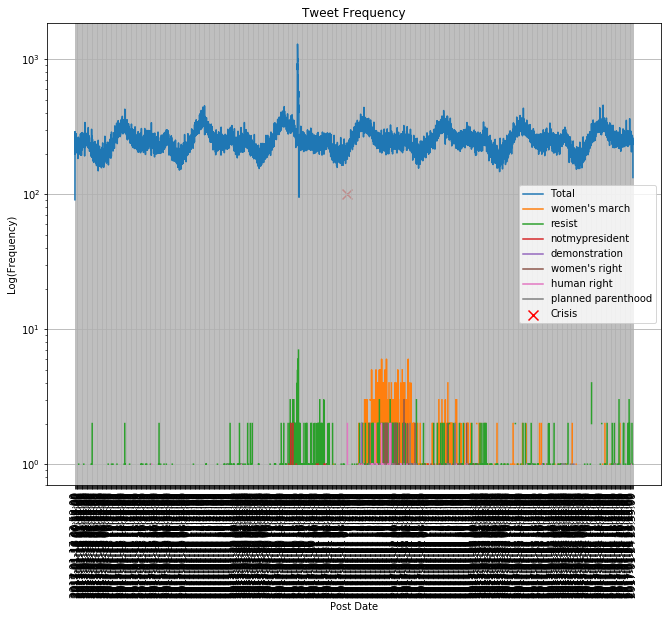

In [69]:
# What keywords are we interested in?
targetKeywords = crisisInfo[selectedCrisis]["keywords"]

# Build an empty map for each keyword we are seaching for
targetCounts = {x:[] for x in targetKeywords}
totalCount = []

# For each minute, pull the tweet text and search for the keywords we want
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # Temporary counter for this minute
    localTargetCounts = {x:0 for x in targetKeywords}
    localTotalCount = 0
    
    for tweetObj in timeObj:
        tweetString = tweetObj["text"].lower()

        localTotalCount += 1
        
        # Add to the counter if the target keyword is in this tweet
        for keyword in targetKeywords:
            if ( keyword in tweetString ):
                localTargetCounts[keyword] += 1
                
    # Add the counts for this minute to the main counter
    totalCount.append(localTotalCount)
    for keyword in targetKeywords:
        targetCounts[keyword].append(localTargetCounts[keyword])
        
# Now plot the total frequency and frequency of each keyword
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)

# Set title
plt.title("Tweet Frequency")

# ticks interval
smallerXTicks = range(0, len(sortedTimes), 15)
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

# Plot in log-scale because overall tweet volume is much higher than relevant volume
ax.semilogy(range(len(frequencyMap)), totalCount, label="Total")

# Plot a simple X where the disaster occurred
ax.scatter([crisisXCoord], [100], c="r", marker="x", s=100, label="Crisis")

# For each keyword in our target keywords...
for keyword in targetKeywords:
    
    # Print the target count for each keyword and time
    ax.semilogy(range(len(frequencyMap)), targetCounts[keyword], label=keyword)
    
# Legend and titles
ax.set_xlabel("Post Date")
ax.set_ylabel("Log(Frequency)")
ax.legend()
ax.grid(b=True, which=u'major')

plt.show()

## Zooming in on textually relevant tweets

We've looked at tweets that happened right after the event, now let's look at tweets that mention the event.

In [70]:
relevant_keyword_tweets = {}

for rel_keyword in targetKeywords:
    relevant_tweets = [tweet 
                       for this_time in 
                           filter(lambda x: x >= crisisTime, sortedTimes) 
                       for tweet in 
                           filter(lambda y: rel_keyword in y["text"].lower(), 
                                  frequencyMap[this_time])
                      ]
    
    relevant_keyword_tweets[rel_keyword] = relevant_tweets
    print("Keyword:", rel_keyword, "Count:", len(relevant_tweets))

Keyword: women's march Count: 2006
Keyword: resist Count: 1322
Keyword: notmypresident Count: 120
Keyword: demonstration Count: 117
Keyword: women's right Count: 521
Keyword: human right Count: 298
Keyword: planned parenthood Count: 310


In [71]:
for target_keyword, textually_relevant_tweets in relevant_keyword_tweets.items():

    print("\n------------------------")
    print("Keyword:", target_keyword, "Count:", len(textually_relevant_tweets))

    # This list comprehension iterates through the tweet_list list, and for each
    #  tweet, it iterates through the hashtags list
    htags = [
            hashtag["text"].lower() 
             for tweet in textually_relevant_tweets 
                 for hashtag in tweet["entities"]["hashtags"]
            ]

    print("Total Hashtag Count:", len(htags))
    print("Unique Hashtag Count:", len(set(htags)))

    htags_freq = nltk.FreqDist(htags)

    print("\nFrequent Hashtags:")
    for tag, count in htags_freq.most_common(20):
        print(tag, count)

    # This list comprehension iterates through the tweet_list list, and for each
    #  tweet, it iterates through the author list
    authors = [tweet["user"]["screen_name"].lower() for tweet in textually_relevant_tweets]

    print("\nTotal Author Count:", len(authors))
    print("Unique Author Count:", len(set(authors)))

    author_freq = nltk.FreqDist(authors)

    print("\nActive Users:")
    for author, count in author_freq.most_common(20):
        print(author, count)

    # This list comprehension iterates through the tweet_list list, and for each
    #  tweet, it iterates through the URL list
    urls = [
            url["expanded_url"]
             for tweet in textually_relevant_tweets 
                 for url in tweet["entities"]["urls"]
            ]

    print("Total URL Count:", len(urls))
    print("Unique URL Count:", len(set(urls)))

    urls_freq = nltk.FreqDist(urls)

    print("\nCommon URLs:")
    for url, count in urls_freq.most_common(20):
        print(url, count)


------------------------
Keyword: women's march Count: 2006
Total Hashtag Count: 386
Unique Hashtag Count: 183

Frequent Hashtags:
womensmarch 136
breakingnews 12
whyimarch 8
lovatics 7
bestfanarmy 5
iheartawards 5
indianapolis 4
indianastatehouse 4
breaking 4
lovetrumpshate 3
women 3
news 3
politics 3
yeg 3
ableg 3
womensmarchonwashington 2
9news 2
toronto 2
periscope 2
theresistance 2

Total Author Count: 2006
Unique Author Count: 2000

Active Users:
michaelawoodjr 2
rxssaaa_16 2
socincolosprgs 2
camillendavis1 2
tyjw_ 2
rukannur 2
alleyezonyou_ 1
joiebutter 1
tp_englenton 1
beckywhin 1
chicagonewsnow 1
sergisuarezm 1
judith2000641 1
jesss_darcy 1
dailyoutfit 1
femdem2021 1
unity_humanity 1
dmckeirnan 1
rarechromomum 1
kellytyrpak 1
Total URL Count: 926
Unique URL Count: 551

Common URLs:
None 255
http://abcn.ws/2kcdI1n 12
http://abc7.la/2jjMnKl 10
http://www.cnn.com/2017/01/21/politics/womens-march-donald-trump-inauguration-sizes/index.html 8
http://thkpr.gs/9e6b47dc21bd 8
https://

### Merging All Relevant Tweets

We looked at tweets that match our relevant keywords. Now let's merge them all together.

In [72]:
all_rel_tweets = {tweet["id"]:tweet 
                  for local_tweet_list in relevant_keyword_tweets.values() 
                  for tweet in local_tweet_list}

print("Unique textually relevant tweets:", len(all_rel_tweets))

Unique textually relevant tweets: 4447


In [73]:
textually_relevant_tweets = list(all_rel_tweets.values())

# This list comprehension iterates through the tweet_list list, and for each
#  tweet, it tokenizes the tweet text
tokens = [
        token.lower() 
         for tweet in textually_relevant_tweets 
             for token in tokenizer.tokenize(tweet["text"])
        ]
tokens = list(filter(lambda x: x not in stops and len(x) > 3, tokens))

print("Total Token Count:", len(tokens))
print("Unique Token Count:", len(set(tokens)))

tokens_freq = nltk.FreqDist(tokens)

print("\nFrequent Tokens:")
for token, count in tokens_freq.most_common(20):
    print(token, count)

# This list comprehension iterates through the tweet_list list, and for each
#  tweet, it iterates through the hashtags list
htags = [
        hashtag["text"].lower() 
         for tweet in textually_relevant_tweets 
             for hashtag in tweet["entities"]["hashtags"]
        ]

print("\nTotal Hashtag Count:", len(htags))
print("Unique Hashtag Count:", len(set(htags)))

htags_freq = nltk.FreqDist(htags)

print("\nFrequent Hashtags:")
for tag, count in htags_freq.most_common(20):
    print(tag, count)

# This list comprehension iterates through the tweet_list list, and for each
#  tweet, it iterates through the author list
authors = [tweet["user"]["screen_name"].lower() for tweet in textually_relevant_tweets]

print("\nTotal Author Count:", len(authors))
print("Unique Author Count:", len(set(authors)))

author_freq = nltk.FreqDist(authors)

print("\nActive Users:")
for author, count in author_freq.most_common(20):
    print(author, count)

# This list comprehension iterates through the tweet_list list, and for each
#  tweet, it iterates through the URL list
urls = [
        url["expanded_url"]
         for tweet in textually_relevant_tweets 
             for url in tweet["entities"]["urls"]
        ]

print("\nTotal URL Count:", len(urls))
print("Unique URL Count:", len(set(urls)))

urls_freq = nltk.FreqDist(urls)

print("\nCommon URLs:")
for url, count in urls_freq.most_common(20):
    print(url, count)

Total Token Count: 42901
Unique Token Count: 11286

Frequent Tokens:
women's 2561
march 2052
rights 1053
#womensmarch 533
trump 390
planned 318
human 313
washington 309
parenthood 303
women 295
resistance 295
#theresistance 285
inauguration 242
trump's 192
today 188
marches 186
people 171
world 151
resist 148
black 146

Total Hashtag Count: 2658
Unique Hashtag Count: 783

Frequent Hashtags:
womensmarch 533
theresistance 285
resist 115
notmypresident 111
resistance 74
trumpleaks 50
resisttrump 44
trump 34
whyimarch 30
womensmarchonwashington 27
resisttrumptuesdays 27
inauguration 21
lovatics 21
breaking 20
bestfanarmy 20
alternativefacts 20
indivisible 20
iheartawards 19
resistfromday1 14
breakingnews 12

Total Author Count: 4447
Unique Author Count: 4409

Active Users:
caminahotx 11
michaelawoodjr 2
skyclad_dancer 2
abracadabrany 2
jamesvicktory 2
rxssaaa_16 2
paulhaider74 2
deeloralei 2
aye_veri 2
socincolosprgs 2
camillendavis1 2
tyjw_ 2
w_i_uk 2
britbwebbhair 2
denihanmary 2
rukannu

Looking at these hashtags, URLs, and users, are there any new tokens we should add to our list of relevant keywords? If so, maybe add them to the crisis map we started above and re-run this notebook.

## Saving Relevant Tweets

For our convenience, we'll go ahead and save these tweets' JSON versions into a separate file, so we don't have to re-read them every time we do want to analysis our data.

In [74]:
with open("/Users/yutingliao/Desktop/INST728 E/relevant_tweet_output_keywords_updated.json", "w") as out_file:
    for tweet in textually_relevant_tweets:
        out_file.write("%s\n" % json.dumps(tweet))